In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __future__ import print_function, division
import six
import pathcustomize, about
about.about()

Python 3.4.3 (default, Mar  6 2015 12:07:41) [GCC 4.2.1 (Apple Inc. build 5577)] on darwin, Host: peters-MacBook-Air.local


In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pathlib

In [4]:
import waldo
from waldo import wio

In [5]:
name_to_eid = {'A': '20160712_161305-1',
 'B': '20160712_131743-3',
 'C': '20160712_140807-1',
 'D': '20160712_142201-2',
 'E': '20160712_105713-1',
 'F': '20160712_125324-2',
 'G': '20160712_163736-3',
 'H': '20160712_162505-2',
 'I': '20160712_130504-1'}

eid_to_name = {}
for a, b in name_to_eid.items():
    eid_to_name[b] = a

# Read data

In [6]:
names = 'ABCDEFGHI'
dfs1 = [pd.read_excel('/Users/peterwinter/Desktop/validation/PeterWinter-Validation.xlsx', 
                     sheetname=i) for i in names]
dfs2 = [pd.read_excel('/Users/peterwinter/Desktop/validation/Renee-Validation.xlsx', 
                      sheetname=i) for i in names]
dfs = [pd.read_excel('/Users/peterwinter/Desktop/validation/consensus-Validation.xlsx', 
                      sheetname=i) for i in names]

# combine all data

In [134]:
def prep_df(df, name='A', name_to_eid=name_to_eid):
    df.columns = [i.strip() for i in df.columns]
    data = df.set_index('Blob_ids')
    good_ids = []
    eid = None
    for i in data.index:
        if type(i) is int:
            if not np.isnan(i):
                good_ids.append(i)
        if type(i) is str and eid is None:
            eid = data.loc[i, 'Start Time']
    
    data = data.loc[good_ids]
    data['eid'] = name_to_eid[name]
    data['name'] = name
    data['bid'] = data['name'] + np.array(data.index, dtype='str')
    data = data.set_index('bid')
    data['minutes'] = (data['End Time'] - data['Start Time']) / (1000. * 60.)
    if 'Was Correct Throughout' in data.columns:
        data.rename(columns={'Was Correct Throughout':'Was Single Worm?'}, inplace=True)
    
    data['good'] = (data['Was Single Worm?'] == 'yes')
    return data, eid

def assign_errors(df):
    multiworm_bids = []
    part_bad_bids = []
    id_switch_bids = []

    for bid, row in df.iterrows():
        if row['good']:
            continue
        if type(row['if, no, why?']) is not str:
            continue

        if row['if, no, why?'] in ['muliworm','multiworm']:
            multiworm_bids.append(bid)
        elif row['if, no, why?'] in ['part-multiword', 'part-multiworm', 'single+collisoin', 'part multiworm']:
            part_bad_bids.append(bid)
        elif 'id-' in row['if, no, why?']:
            id_switch_bids.append(bid)
            #print(bid, row['if, no, why?'])
        elif 'id switch' in row['if, no, why?']:
            id_switch_bids.append(bid)
        elif row['if, no, why?'] == 'part-multiworm, id-switch':
            id_switch_bids.append(bid)
            part_bad_bids.append(bid)
        else:
            print('? == ({})'.format( row['if, no, why?']))



    df['collision'] = False
    df['part-bad'] = False
    df['id-switch'] = False

    df.loc[multiworm_bids, 'collision'] = True
    df.loc[part_bad_bids, 'part-bad'] = True
    df.loc[id_switch_bids, 'id-switch'] = True

# data = prep_df(dfs[0])
# assign_errors(data)
# data.head().T
def combine_dfs_from_sheet(names, dfs, eid_to_name, name_to_eid):
    all_data = []
    for name, df in zip(names, dfs):
        data, eid = prep_df(df, name=name)
        assign_errors(data)
        eid = name_to_eid[name]
        print(name, eid)
        all_data.append(data)
        name_to_eid[name] = eid
        eid_to_name[eid] = name

    df = pd.concat(all_data, axis=0)
    df = df[df['Was Single Worm?'].isnull() == False]
    return df

df = combine_dfs_from_sheet(names, dfs, eid_to_name, name_to_eid)
#print(len(df))
df.head().T

A 20160712_161305-1
B 20160712_131743-3
C 20160712_140807-1
D 20160712_142201-2
E 20160712_105713-1
F 20160712_125324-2
G 20160712_163736-3
H 20160712_162505-2
I 20160712_130504-1


bid,A1,A2,A3,A4,A5
Start Time,10,10,10,10,10
End Time,600070,305632,194933,600070,128800
Worms next ID,NaN,216,140,NaN,105
Was Single Worm?,yes,no,yes,yes,no
"if, no, why?",NaN,part-multiworm,NaN,NaN,part-multiworm
Reason Lost,NaN,collision,edge,NaN,NaN
# Correct Collisions,1,2,1,NaN,NaN
# Wrong Collisions,NaN,NaN,NaN,NaN,NaN
# Wrong Gaps,NaN,NaN,NaN,NaN,NaN
eid,20160712_161305-1,20160712_161305-1,20160712_161305-1,20160712_161305-1,20160712_161305-1


In [8]:
df.columns

Index(['Start Time', 'End Time', 'Worms next ID', 'Was Single Worm?',
       'if, no, why?', 'Reason Lost', '# Correct Collisions',
       '# Wrong Collisions', '# Wrong Gaps', 'eid', 'name', 'minutes', 'good',
       'collision', 'part-bad', 'id-switch'],
      dtype='object')

# Reviewer Agreement Check

In [9]:
df1 = combine_dfs_from_sheet(names, dfs1, eid_to_name, name_to_eid)
df2 = combine_dfs_from_sheet(names, dfs2, eid_to_name, name_to_eid)
print(df2.columns)
check = pd.concat([df1[['good', 'if, no, why?']].rename(columns={'good':'me', 'if, no, why?':'me2'}),
                   df2[['good', 'if, no, why?']].rename(columns={'good':'other', 'if, no, why?':'other2'})], axis=1)

check['agree'] = (check['me'] == check['other'])

agreement = check.agree.sum() /check.agree.count()
print('validators agree on', agreement, 'of tracks')
my_score = check['me'].sum() /check['me'].count()
her_score = check['other'].sum() /check['other'].count()
print('my score', my_score)
print('her score', her_score)

disagreement = check[check['agree'] == False]
print(len(disagreement))
disagreement.index

A 20160712_161305-1
B 20160712_131743-3
C 20160712_140807-1
D 20160712_142201-2
E 20160712_105713-1
F 20160712_125324-2
G 20160712_163736-3
H 20160712_162505-2
I 20160712_130504-1
A 20160712_161305-1
B 20160712_131743-3
C 20160712_140807-1
D 20160712_142201-2
E 20160712_105713-1
F 20160712_125324-2
G 20160712_163736-3
H 20160712_162505-2
I 20160712_130504-1
Index(['Start Time', 'End Time', 'Was Single Worm?', 'if, no, why?',
       'Unnamed: 5', 'Unnamed: 6', 'eid', 'name', 'minutes', 'good',
       'collision', 'part-bad', 'id-switch'],
      dtype='object')
validators agree on 0.968253968254 of tracks
my score 0.819047619048
her score 0.819047619048
10


Index(['A10', 'A34', 'B81', 'D7', 'D14', 'H15', 'H28', 'H103', 'H683', 'I6'], dtype='object', name='bid')

In [10]:
#A10 goes bad last instant: 0408061
#A34 starts as multi. (12 and 23). fine after 0024956 (ends with one untracked)
#B81 starts as multi. fine after 0250812 (ends with one moving into next collision/three worm collision)
#D7 seems fine. My bad
#D14 fine until 0193175. (makes contact with untracked worm. speration ends track)
#H15 seems fine.
#H28 /H103 ??? Crap! This is another one!
#H683 starts multi. good after 0505013
#I6 seems fine.


real = [("A10",False), 
("A34",False), 
("B81",False), 
("D7",True), 
("D14",False), 
("H15",True), 
("H28",True),
("H103",True), 
("H683",False), 
("I6",True)]
index, vals = zip(*real)
disagreement.loc[index, 'Truth'] = pd.Series(vals, index=index)
disagreement['true_reason'] = np.nan
bads = disagreement[disagreement['Truth'] == False]
disagreement.loc[bads.index, 'true_reason'] = 'part-multiworm'

/Users/peterwinter/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/pandas/core/indexing.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/peterwinter/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/pandas/core/indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/peterwinter/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/IPython/kernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [11]:
# df.loc[disagreement.index, 'Was Single Worm?'] = disagreement['Truth']
# df.loc[disagreement.index, 'if, no, why?'] = disagreement['true_reason']
# df.loc[disagreement.index, 'part_bad'] = True

# assign_errors(df)

In [12]:
# assign_errors(df)
# df.loc["H683"]

# Back to using just my Scoring Results

In [13]:
name_to_eid['D']

'20160712_142201-2'

In [14]:
df.loc[df['id-switch'], ['if, no, why?', '# Correct Collisions']]

,"if, no, why?",# Correct Collisions
bid,,
A245,"part-multiworm, id-switch",joins_w_untrackedworm.then-label-switches.toun...
C2,id-switch(2-10),two-worm
C10,id-switch(2-10),two-worm
C11,id-switch(11-12),two-worm
C12,id-switch(11-12),two-worm
D3,id-switch(3-28),two-worm
D13,id-switch(13-29),threeway-with-untracked-worm.untracked-gains-l...
D28,id-switch(3-28),two-worm
G52,"id-switch(52,57)","three-way-collision(57,47,52)"


# Estimate The Tracks with MWT

In [15]:
a = pathlib.Path('/Users/peterwinter/Desktop/validation/MWT/')
es = {}
for i in a.glob('*'):
    if not i.is_dir():
        continue
    print(i.name, eid_to_name[i.name])
    e = wio.Experiment(fullpath=str(i))
    es[eid_to_name[i.name]] = e

20160712_105713-1 E
20160712_125324-2 F
20160712_130504-1 I
20160712_131743-3 B
20160712_140807-1 C
20160712_142201-2 D
20160712_161305-1 A
20160712_162505-2 H
20160712_163736-3 G


In [16]:
MWT_data = []
for name, e in es.items():
    n_blobs = 0
    n_m_blobs = 0
    
    for i in e:
        bdf = e[i].df
        if bdf is not None:
            n_blobs += 1
            dt = bdf['time'].iloc[-1] - bdf['time'].iloc[0]
            if dt > 60:
                n_m_blobs += 1

            
            
    MWT_data.append((name, name_to_eid[name], n_blobs, n_m_blobs))
    print(name, name_to_eid[name], n_blobs, n_m_blobs)

mwt_df = pd.DataFrame(MWT_data, columns=['name', 'eid', 'MWT Tracks', '>1m']).set_index('name')
mwt_df

C 20160712_140807-1 505 49
I 20160712_130504-1 160 34
D 20160712_142201-2 368 44
F 20160712_125324-2 239 37
A 20160712_161305-1 357 55
H 20160712_162505-2 783 72
E 20160712_105713-1 55 20
G 20160712_163736-3 611 56
B 20160712_131743-3 160 35


,eid,MWT Tracks,>1m
name,,,
C,20160712_140807-1,505,49
I,20160712_130504-1,160,34
D,20160712_142201-2,368,44
F,20160712_125324-2,239,37
A,20160712_161305-1,357,55
H,20160712_162505-2,783,72
E,20160712_105713-1,55,20
G,20160712_163736-3,611,56
B,20160712_131743-3,160,35


# get numbers of curated tracks

In [17]:
l = df[df['Reason Lost'].isnull() == False]
human_data = []
for name, d in df.groupby('name'):
    human_joins = len(d[d['Worms next ID'].isnull() == False])
    non_collisions = len(d[d['collision'] == False])
    total_tracks = len(d)
    print(name, human_joins, non_collisions)
    
    
    #human_number
    human_data.append((name, total_tracks, non_collisions, human_joins))
    
hdf = pd.DataFrame(human_data, columns=['name', 'total_tracks', 'non_collisions', 'Human joins']).set_index('name')
hdf['Human Tracks'] = hdf['total_tracks'] - hdf['Human joins']
hdf['Human Worm Tracks'] = hdf['non_collisions'] - hdf['Human joins']
hdf

A 17 47
B 5 23
C 7 34
D 7 33
E 1 14
F 5 24
G 7 33
H 18 50
I 7 34


,total_tracks,non_collisions,Human joins,Human Tracks,Human Worm Tracks
name,,,,,
A,48,47,17,31,30
B,24,23,5,19,18
C,37,34,7,30,27
D,38,33,7,31,26
E,14,14,1,13,13
F,24,24,5,19,19
G,35,33,7,28,26
H,58,50,18,40,32
I,37,34,7,30,27


In [18]:
hdf.sum()

total_tracks         315
non_collisions       292
Human joins           74
Human Tracks         241
Human Worm Tracks    218
dtype: int64

# WALDO's Output

In [19]:
n_worms = {'A':30, 
           'B':17,
           'C':24,
           'D':24,
           'E':12,
           'F':18,
           'G':28,
           'H':30,
           'I':25,
          }

sum_ds = []
for name, d in df.groupby('name'):
    missing_joins = d[d['Worms next ID'].isnull() == False]
    d['dt'] = d['End Time'] - d['Start Time']
    s ={'name':name,
        '#worms':n_worms[name],
        '#tracks': len(d),
        'fully_correct': len(d[d['good']]),
        'part-bad': len(d[d['part-bad']]),
        'collision': len(d[d['collision']]),
        'id-switch': len(d[d['id-switch']]),
        'missing_joins': len(missing_joins),
        'w>1m': len(d[d['dt'] > 60*1000]),
    }
    sum_ds.append(s)
    
sdf = pd.DataFrame(sum_ds).set_index('name')
sdf = sdf[['#worms', '#tracks', 'missing_joins', 'fully_correct', 'id-switch', 'part-bad', 'collision', 'w>1m']]
sdf.sort('#worms')

/Users/peterwinter/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/IPython/kernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/peterwinter/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/IPython/kernel/__main__.py:30: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,#worms,#tracks,missing_joins,fully_correct,id-switch,part-bad,collision,w>1m
name,,,,,,,,
E,12,14,1,14,0,0,0,14
B,17,24,5,21,0,2,1,23
F,18,24,5,23,0,1,0,21
C,24,37,7,30,4,0,3,30
D,24,38,7,28,3,2,5,32
I,25,37,7,30,4,0,3,30
G,28,35,7,31,2,0,2,27
A,30,48,17,40,1,6,1,40
H,30,58,18,40,2,8,8,45


In [20]:
main_table = pd.concat([sdf, hdf, mwt_df], axis=1)
# .rename(columns={'#tracks': 'WALDO Tracks','id-switch': 'Tracks id-switch'})
main_table['WALDO Tracks Id-preserved'] = main_table['#tracks'] - main_table['id-switch']
main_table = main_table[['#worms', 'MWT Tracks', '#tracks', 'Human Tracks', 'WALDO Tracks Id-preserved', 'id-switch']]
main_table = main_table.rename(columns={'#tracks': '#Tracks, WALDO',
                                        'MWT Tracks': '#Tracks, MWT',
                                        'Human Tracks': '#Tracks, Human',
                                        'id-switch': 'WALDO Tracks Id-switched',
                                       })
main_table = main_table.sort('#worms')
main_table = main_table.reset_index()
main_table = main_table.drop('index', axis=1)
main_table.loc['totals'] = main_table.sum()
main_table.index.name = 'recording'
main_table.to_csv('track_val.csv')
main_table

/Users/peterwinter/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/IPython/kernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,#worms,"#Tracks, MWT","#Tracks, WALDO","#Tracks, Human",WALDO Tracks Id-preserved,WALDO Tracks Id-switched
recording,,,,,,
0,12,55,14,13,14,0
1,17,160,24,19,24,0
2,18,239,24,19,24,0
3,24,505,37,30,33,4
4,24,368,38,31,35,3
5,25,160,37,30,33,4
6,28,611,35,28,33,2
7,30,357,48,31,47,1
8,30,783,58,40,56,2


In [21]:
tots = main_table.loc['totals']
A2 = 'percent of tracks switched', 100 * tots['WALDO Tracks Id-switched'] / tots['#Tracks, WALDO'] 
B2 = 'percent of tracks fine', 100 * tots['WALDO Tracks Id-preserved'] / tots['#Tracks, WALDO']

print(A2)
print(B2)

100 * tots['#Tracks, WALDO'] / tots['#Tracks, MWT']

('percent of tracks switched', 5.0793650793650791)
('percent of tracks fine', 94.920634920634924)


9.7282273008029652

In [22]:
mtab2 = pd.concat([sdf, hdf, mwt_df], axis=1)
#.rename(columns={'#tracks': 'WALDO Tracks','id-switch': 'Tracks id-switch'})
mtab2['WALDO Tracks Id-preserved'] = mtab2['#tracks'] - mtab2['id-switch']
mtab2 = mtab2[['#worms', '>1m', 'w>1m', 'Human Worm Tracks', 'id-switch']]
mtab2 = mtab2.rename(columns={'#tracks': '#Tracks, WALDO',
                                        #'MWT Tracks': '#Tracks, MWT',
                                        'Human Tracks': '#Tracks, Human',
                                        'id-switch': 'WALDO Tracks Id-switched',
                                       })
mtab2 = mtab2.sort('#worms')
mtab2 = mtab2.reset_index()
mtab2 = mtab2.drop('index', axis=1)
mtab2.loc['totals'] = mtab2.sum()
mtab2.index.name = 'recording'
mtab2.to_csv('track_val2.csv')
mtab2

/Users/peterwinter/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/IPython/kernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,#worms,>1m,w>1m,Human Worm Tracks,WALDO Tracks Id-switched
recording,,,,,
0,12,20,14,13,0
1,17,35,23,18,0
2,18,37,21,19,0
3,24,49,30,27,4
4,24,44,32,26,3
5,25,34,30,27,4
6,28,56,27,26,2
7,30,55,40,30,1
8,30,72,45,32,2


In [142]:
100 * 2 / 262

16 / 315

0.050793650793650794

In [23]:
# tots = mtab2.loc['totals']
# A2 = 'percent of tracks switched', 100 * tots['WALDO Tracks Id-switched'] / tots['w>1m'] 
# B2 = 'percent of tracks fine', 100 * tots['WALDO Tracks Id-preserved'] / tots['w>1m']
# print(A2)
# print(B2)

# 100 * tots['#Tracks, WALDO'] / tots['#Tracks, MWT']

# Percentages

/Users/peterwinter/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/IPython/kernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


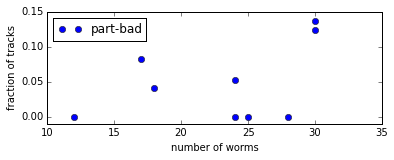

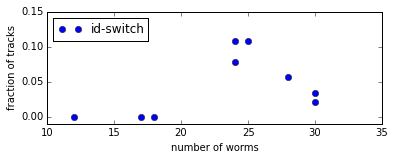

In [24]:
sdf2 = sdf.copy()
sdf2['id-switch'] = sdf2['id-switch']/ sdf2['#tracks']
sdf2['part-bad'] = sdf2['part-bad']/  sdf2['#tracks']
sdf2['collision'] = sdf2['collision']/  sdf2['#tracks']
sdf2['fully_correct'] = sdf2['fully_correct']/  sdf2['#tracks']
sdf2 = sdf2.sort('#worms')

fig, ax = plt.subplots(figsize=(6, 2))
for i in [ 'part-bad']: #, 'id-switch']: #'fully_correct',
    ax.plot(sdf2['#worms'], sdf2[i], 'o', label=i)
ax.legend(loc='best')
ax.set_xlabel('number of worms')
ax.set_ylabel('fraction of tracks')
ax.set_yticks([0.00, 0.05, 0.10, 0.15])
ax.set_xlim(10, 35)
ax.set_ylim(-0.01, 0.15)
plt.show()

fig, ax = plt.subplots(figsize=(6, 2))
for i in [ 'id-switch']: #, 'id-switch']: #'fully_correct',
    ax.plot(sdf2['#worms'], sdf2[i], 'o', label=i)
ax.legend(loc='upper left')
ax.set_xlabel('number of worms')
ax.set_ylabel('fraction of tracks')
ax.set_yticks([0.00, 0.05, 0.10, 0.15])
ax.set_xlim(10, 35)
ax.set_ylim(-0.01, 0.15)
plt.show()

In [25]:
# print('good throughout', df['good'].sum() / df['good'].count())

# Collision Accuracy

In [26]:
print('good {0:.2f}'.format( 100 * len(df[df['good']])/ len(df)), len(df[df['good']]))
print('id-switch {0:.2f}'.format(100 * len(df[df['id-switch']])/ len(df)), len(df[df['id-switch']]))
print('collision {0:.2f}'.format( 100 * len(df[df['collision']])/ len(df)), len(df[df['collision']]))
print('part-bad {0:.2f}'.format(100 * len(df[df['part-bad']])/ len(df)), len(df[df['part-bad']]))

good 81.59 257
id-switch 5.08 16
collision 7.30 23
part-bad 6.03 19


In [27]:
# unique_id_switches = []
# for name, d in df2.groupby('name'):
#     id_switches = set(d.loc[d['id-switch'], 'if, no, why?'])
#     unique_id_switches.append((name, len(id_switches)))
    
# unique_id_switches = pd.DataFrame(unique_id_switches, columns=['name', 'id-switch-events']).set_index('name')
# unique_id_switches

In [28]:
id_switch_collisions = pd.Series({'A':0, 
                                  'B':0,
                                  'C':2,
                                  'D':1,
                                  'E':0,
                                  'F':0,
                                  'G':0,
                                  'H':1,
                                  'I':2,
                                 })
other_id_switch_events = pd.Series({'A':1, 
                                  'B':0,
                                  'C':0,
                                  'D':1,
                                  'E':0,
                                  'F':0,
                                  'G':1,
                                  'H':0,
                                  'I':0,
                                 })

id_switch_collisions


A    0
B    0
C    2
D    1
E    0
F    0
G    0
H    1
I    2
dtype: int64

In [29]:
WALDO_DIR = pathlib.Path('/Users/peterwinter/Desktop/validation/param_gap_pix50/')
cdata = []

for wdir in WALDO_DIR.glob('*'):
    if not wdir.is_dir():
        continue
        
    eid = wdir.name
    colision_rep = wdir / 'waldo' / (eid + '-collisions.csv')
    #print(colision_rep.is_file)
    cdf = pd.read_csv(str(colision_rep), index_col=0)
    #print(cdf.head())
    unresolved = cdf[cdf['fail_reason'] == 'no_overlap']
    unresolved['check1'] = np.array(unresolved['c0'], dtype=str) 
    unresolved['check2'] = np.array(unresolved['c1'], dtype=str)
    unresolved['check'] = unresolved['check1'] + '-' + unresolved['check2']
    n_unresolved = len(set(unresolved['check']))

    n_resolved = len(cdf[cdf['resolved']])
    c = {'name': eid_to_name[eid],
         'eid':eid,
         'resolved collisions': n_resolved,
         'unresolved collisions': n_unresolved,
         '#collisions': n_resolved + n_unresolved,
    }
    cdata.append(c)
cdf = pd.DataFrame(cdata)
cdf =cdf.set_index('name')
cdf['#worms'] = sdf['#worms']
cdf['id-switch collision'] = id_switch_collisions
cdf['other id-switch events'] = other_id_switch_events

#cdf['id-switch events'] = unique_id_switches['id-switch-events']

csums = cdf.sum(axis=0)
csums
cdf = cdf[['#worms', '#collisions', 'resolved collisions', 'unresolved collisions', 
           'id-switch collision', 'other id-switch events']]
cdf= cdf.sort('#worms')
cdf = cdf.reset_index()
print(cdf)
cdf = cdf.drop('name', axis=1)
cdf.loc['totals'] = cdf.sum()
cdf.index.name = 'recording'
cdf.to_csv('collision_val.csv')
cdf

/Users/peterwinter/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/IPython/kernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/peterwinter/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/IPython/kernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/peterwinter/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/IPython/kernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

  name  #worms  #collisions  resolved collisions  unresolved collisions  \
0    E      12           13                    9                      4   
1    B      17           32                   22                     10   
2    F      18           48                   36                     12   
3    C      24           99                   75                     24   
4    D      24           45                   28                     17   
5    I      25           32                   25                      7   
6    G      28           89                   61                     28   
7    A      30           66                   48                     18   
8    H      30           98                   72                     26   

   id-switch collision  other id-switch events  
0                    0                       0  
1                    0                       0  
2                    0                       0  
3                    2                       0  
4   

,#worms,#collisions,resolved collisions,unresolved collisions,id-switch collision,other id-switch events
recording,,,,,,
0,12,13,9,4,0,0
1,17,32,22,10,0,0
2,18,48,36,12,0,0
3,24,99,75,24,2,0
4,24,45,28,17,1,1
5,25,32,25,7,2,0
6,28,89,61,28,0,1
7,30,66,48,18,0,1
8,30,98,72,26,1,0


In [30]:
tots = cdf.loc['totals']
A ='chance of resolved creating id switch', 100 * tots['id-switch collision'] / tots['resolved collisions']
B = 'chance of resolvig collision', tots['resolved collisions'] / tots['#collisions']
print(A)
print(B)

('chance of resolved creating id switch', 1.5957446808510638)
('chance of resolvig collision', 0.72030651340996166)


In [133]:
switches = set(df.loc[df['id-switch'], 'if, no, why?'])
print(len(switches))
switches

9


{'id-switch(11,12)',
 'id-switch(11-12)',
 'id-switch(13-29)',
 'id-switch(2-10)',
 'id-switch(24,69)',
 'id-switch(3,10)',
 'id-switch(3-28)',
 'id-switch(52,57)',
 'part-multiworm, id-switch'}

In [137]:
cols = df[df['collision']]
short_collisions = len(cols[cols['minutes']<.75])
long_collisions = len(cols[cols['minutes']>.75])
total_collisions = len(cols)
short_collisions / total_collisions
cols[cols['minutes']>.75]

,Start Time,End Time,Worms next ID,Was Single Worm?,"if, no, why?",Reason Lost,# Correct Collisions,# Wrong Collisions,# Wrong Gaps,eid,name,minutes,good,collision,part-bad,id-switch
bid,,,,,,,,,,,,,,,,
D202,300234,538601,NaN,no,multiworm,NaN,NaN,NaN,NaN,20160712_142201-2,D,3.97278,False,True,False,False
D223,378000,600067,NaN,no,multiworm,NaN,NaN,NaN,NaN,20160712_142201-2,D,3.70112,False,True,False,False


# Key Ideas

In [32]:
print('all observed id-switches were due to collisions, not from infering false edges')
print('of {ncols} resolved collisions, {nswitch} id-switches were observed'.format(ncols=csums['#collisions'], 
                                                                                   nswitch=len(switches)))
print('this is an error rate of {0:0.2f} %'.format(100 * 10 / 376))
print('However, since tracks undergo multiple collisions. ')
print()
print('the second most common error produced by WALDO was to include breif periods'
      ' where two animals were touching,as data coming from a single animal. We identified X such instances')
print ('The longest such event in tracks that contained this error, it lasted XYZ.')

print('Lastly, there was one instance ')

all observed id-switches were due to collisions, not from infering false edges
of 522 resolved collisions, 9 id-switches were observed
this is an error rate of 2.66 %
However, since tracks undergo multiple collisions. 

the second most common error produced by WALDO was to include breif periods where two animals were touching,as data coming from a single animal. We identified X such instances
The longest such event in tracks that contained this error, it lasted XYZ.
Lastly, there was one instance 


In [33]:
# print('good {0:.2f}'.format( 100 * len(df2[df2['good']])/ len(df2)), len(df[df['good']]))
# print('id-switch {0:.2f}'.format(100 * len(id_switch_bids)/ len(df2)), len(id_switch_bids))
# print('collision {0:.2f}'.format( 100 * len(multiworm_bids)/ len(df2)), len(multiworm_bids))
# print('part-bad {0:.2f}'.format(100 * len(part_bad_bids)/ len(df2)), len(part_bad_bids))

NameError: name 'multiworm_bids' is not defined

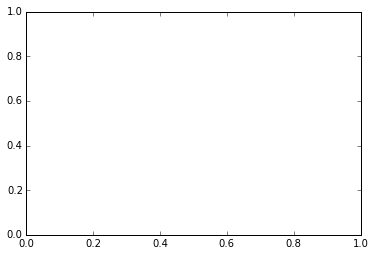

In [117]:
# fig, ax = plt.subplots()
# df.loc[df['good'], 'minutes'].hist(ax=ax)
# ax.set_title('good')
# plt.show()

fig, ax = plt.subplots()
df.loc[multiworm_bids, 'minutes'].hist(ax=ax)
ax.set_title('collision')
plt.show()


# fig, ax = plt.subplots()
# df.loc[part_bad_bids, 'minutes'].hist(ax=ax)
# ax.set_title('part-bad')
# plt.show()


# fig, ax = plt.subplots()
# df.loc[id_switch_bids, 'minutes'].hist(ax=ax)
# ax.set_title('id-switch')
# plt.show()

In [35]:
# 100 * len(id_switch_bids) / len(df)

In [36]:
# for name, df in zip(names, dfs):
#     df['name'] = name
#     df['bid'] = df['name'] + np.array(df['Blob_ids'], dtype='str')

In [37]:
# all_mistakes

In [38]:
#     print(name, data['good'].sum() / data['good'].count())
#     mistakes = data['if, no, why?'].dropna()
#     all_mistakes.append(mistakes)

# Check for any leaf joining (ie. Gaps)

In [39]:
# l = losses[losses['Worms next ID'].isnull() == False]
# l

In [40]:
losses = df[df['Reason Lost'].isnull() == False][['Reason Lost', 'Worms next ID', 'name']]
losses['possible_gap'] = (losses['Worms next ID'].isnull() == False)
losses = losses[losses['Reason Lost'] != 'collision']
losses

,Reason Lost,Worms next ID,name,possible_gap
bid,,,,
A3,edge,140,A,True
A18,dissapear,25,A,True
A34,edge,NaN,A,False
A44,dissapear,82,A,True
C1,disappear,23,C,True
C12,edge,290,C,True
C29,edge,NaN,C,False
D18,disappear,48,D,True
E10,background-spot,33,E,True


In [41]:
WALDO_DIR = pathlib.Path('/Users/peterwinter/Desktop/validation/param_gap_pix50/')
gap_data = []
gaps = []
for wdir in WALDO_DIR.glob('*'):
    if not wdir.is_dir():
        continue
        
    eid = wdir.name
    colision_rep = wdir / 'waldo' / (eid + '-gap_record.csv')
    rdf = pd.read_csv(str(colision_rep), index_col=0)
    n_resolved = len(rdf)
    
    d = losses[losses['name'] == eid_to_name[eid]]
    d = d[d['possible_gap']]
    n_unresolved = len(d)
    
    g = {'name': eid_to_name[eid],
         'eid':eid,
         'detected gaps': n_resolved,
         'undetected gaps': n_unresolved,
         'total gaps': n_unresolved + n_resolved,
         'false gaps': 0,
    }
    
    gaps.append(g)
gaps = pd.DataFrame(gaps).set_index('name')
gaps['#worms'] = sdf['#worms']
gaps= gaps.sort('#worms')

gaps = gaps[['#worms', 'total gaps', 'detected gaps','undetected gaps', 'false gaps']]
gaps = gaps.reset_index()
gaps = gaps.drop('name', axis=1)
gaps.loc['totals'] = gaps.sum()
gaps.index.name = 'recording'
gaps.to_csv('gaps_val.csv')
gaps

/Users/peterwinter/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/IPython/kernel/__main__.py:28: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,#worms,total gaps,detected gaps,undetected gaps,false gaps
recording,,,,,
0,12,1,0,1,0
1,17,0,0,0,0
2,18,4,1,3,0
3,24,4,2,2,0
4,24,8,7,1,0
5,25,4,2,2,0
6,28,4,0,4,0
7,30,4,1,3,0
8,30,5,1,4,0


In [42]:
tots = gaps.loc['totals']
available_gaps = tots['detected gaps'] / tots['total gaps']
false_gaps = tots['false gaps'] / tots['total gaps']

In [44]:
# WALDO_DIR = pathlib.Path('/Users/peterwinter/Desktop/validation/param_col30/')
# cdata = []

# for wdir in WALDO_DIR.glob('*'):
#     if not wdir.is_dir():
#         continue
        
#     eid = wdir.name
#     colision_rep = wdir / 'waldo' / (eid + '-collisions.csv')
#     cdf = pd.read_csv(str(colision_rep), index_col=0)
    
#     unresolved = cdf[cdf['fail_reason'] == 'no_overlap']
#     unresolved['check1'] = np.array(unresolved['c0'], dtype=str) 
#     unresolved['check2'] = np.array(unresolved['c1'], dtype=str)
#     unresolved['check'] = unresolved['check1'] + '-' + unresolved['check2']
#     n_unresolved = len(set(unresolved['check']))

#     n_resolved = len(cdf[cdf['resolved']])
#     c = {'name': eid_to_name[eid],
#          'eid':eid,
#          'resolved': n_resolved,
#          'unresolved': n_unresolved,
#          '#collisions': n_resolved + n_unresolved,
#     }
#     cdata.append(c)
# cdf = pd.DataFrame(cdata).set_index('name')
# cdf['#worms'] = sdf['#worms']
# cdf['id-switch-events'] = unique_id_switches['id-switch-events']

# csums = cdf.sum(axis=0)
# csums
# cdf = cdf[['#worms', '#collisions', 'resolved', 'unresolved', 'id-switch-events']]
# cdf = cdf.reset_index()
# cdf = cdf.drop('name', axis=1)
# cdf.loc['totals'] = cdf.sum()
# cdf.index.name = 'recording'
# print(cdf)
# cdf.to_csv('collision_val.csv')

In [45]:
WALDO_DIR = pathlib.Path('./WALDO/')
gap_data = []


# for wdir in WALDO_DIR.glob('*'):
#     if not wdir.is_dir():
#         continue
        
#     eid = wdir.name
#     colision_rep = wdir / 'waldo' / (eid + '-report-card.csv')
#     rdf = pd.read_csv(str(colision_rep), index_col=0)
#     rdf['dnodes'] = rdf['total-nodes'].diff()
#     rdf = rdf[['total-nodes', 'step', 'dnodes']]
#     rdf = rdf[rdf['step'] == 'infer gaps']
#     n_gaps = int(np.abs(rdf.dnodes.sum()))

#     c = {'name': eid_to_name[eid],
#          'eid':eid,
#          '#gaps': n_gaps,
#          }
#     gap_data.append(c)
    
# gdf = pd.DataFrame(gap_data).set_index('name').sort()

# print(gdf['#gaps'].sum(), 'gaps joined in this dataset!')
# gdf

In [47]:
losses = df[df['Reason Lost'].isnull() == False][['Reason Lost', 'Worms next ID']]
losses['possible_gap'] = (losses['Worms next ID'].isnull() == False)
losses = losses[losses['Reason Lost'] != 'collision']
#losses[losses['Reason Lost'] == 'edge']
losses

,Reason Lost,Worms next ID,possible_gap
bid,,,
A3,edge,140,True
A18,dissapear,25,True
A34,edge,NaN,False
A44,dissapear,82,True
C1,disappear,23,True
C12,edge,290,True
C29,edge,NaN,False
D18,disappear,48,True
E10,background-spot,33,True


In [48]:
print('{} more possible gaps were joined by eye'.format(losses['possible_gap'].sum()))

20 more possible gaps were joined by eye


# Overlap Plot

In [49]:
overlap = pathlib.Path('/Users/peterwinter/Desktop/validation/quick_test/')
waldo = pathlib.Path('/Users/peterwinter/Desktop/validation/WALDO/')

all_overlap_data = []
all_nodes = []
for wdir in overlap.glob('*'):
    if not wdir.is_dir():
        continue
        
    eid = wdir.name
    col_ov_path = wdir / 'waldo' / (eid + '-collision-overlaps.csv')
    col_path = wdir / 'waldo' / (eid + '-collisions.csv')
    node_path = wdir / 'waldo' / (eid + '-node-summary.csv')

    if not col_ov_path.is_file():
        print(eid_to_name[eid], 'missing overlap file')
        #print(wdir, 'has col ov')
        continue
        
    print(wdir.name)
    overlap_df = pd.read_csv(str(col_ov_path), index_col=0)
    node_df = pd.read_csv(str(node_path), index_col=0)
    overlap_df.columns=['parents', 'children', 'overlap1', 'overlap2']
    overlap_df['eid'] = eid
    overlap_df['name'] = eid_to_name[eid]
    node_df['eid'] = eid
    node_df['name'] = eid_to_name[eid]
    overlap_df['pix_dif'] = np.abs(overlap_df['overlap1'] - overlap_df['overlap2'])
    all_overlap_data.append(overlap_df)
    all_nodes.append(node_df)


# overlap_df['pix_dif'].hist(bins=60)

20160712_105713-1
20160712_125324-2
20160712_130504-1
20160712_131743-3
20160712_140807-1
20160712_142201-2
20160712_161305-1
20160712_162505-2
20160712_163736-3


In [50]:
overlap_df = pd.concat(all_overlap_data, axis=0)
node_df = pd.concat(all_nodes, axis=0)
overlap_df.head()

,parents,children,overlap1,overlap2,eid,name,pix_dif
0,32_4,35_36,928,928,20160712_105713-1,E,0
1,38_39,41_42,904,904,20160712_105713-1,E,0
2,1_13,16_15,237,35,20160712_105713-1,E,202
3,2_11,19_20,0,793,20160712_105713-1,E,793
4,17_13,54_55,410,0,20160712_105713-1,E,410


In [148]:
name = 'H'
print(name_to_eid[name])
n = node_df[node_df['name'] == name]

aa1 = 28
aa2 = 103
a1 = [int(i) for i in n.loc[aa1, 'components'].split('-')]
print(a1)
a2 = [int(i) for i in n.loc[aa2, 'components'].split('-')]
print(a2)

#test c2 and c10
o = overlap_df[overlap_df['name'] == name]
# a1 = [int(i) for i in '10-142-144-145-148-248-252-62'.split('-')]
# a2 = [int(i) for i in '2-76-149-143'.split('-')]
# a1 = [11]
# a2 = [12]

for i, row in o.iterrows():
    p1, p2 = [int(i) for i in row['parents'].split('_')]
    c1, c2 = [int(i) for i in row['children'].split('_')]
    #print(p1, p2)
    p1_in_a1 =  p1 in a1
    p1_in_a2 =  p1 in a2
    p2_in_a1 =  p2 in a1
    p2_in_a2 =  p2 in a2    
    
    if p1_in_a1 and p2_in_a2:
        print('hey')
        print(row)
    elif p1_in_a1 and p2_in_a1:
        print('hey2')

20160712_162505-2
[224, 162, 238, 114, 84, 246, 215, 218, 28]
[163, 103]
hey
parents               114_103
children              154_155
overlap1                  706
overlap2                  706
eid         20160712_162505-2
name                        H
pix_dif                     0
Name: 9, dtype: object
hey
parents               114_103
children              162_163
overlap1                  251
overlap2                    0
eid         20160712_162505-2
name                        H
pix_dif                   251
Name: 73, dtype: object


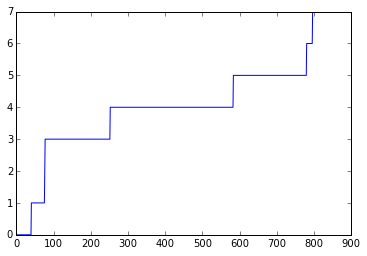

In [149]:
bad_overlaps = np.array([39, 75, 76, 251, 582, 779, 795])
all_ov = np.array(overlap_df['pix_dif'])
bx = np.arange(0, 900)
by = []
by2 = []
by3 = []
by4 = []

for xi in bx:
    by.append(len(bad_overlaps[bad_overlaps<xi]))
    by2.append(len(all_ov[all_ov<xi]))
    by3.append(len(bad_overlaps[bad_overlaps>xi]))
    by4.append(len(all_ov[all_ov>xi]))
    
plt.plot(bx, by)

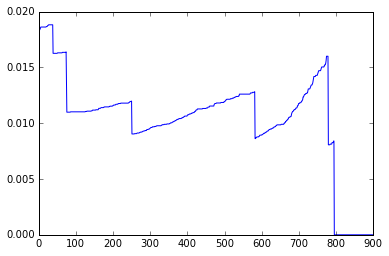

In [150]:
id_switch_rate = np.array(by3)/np.array(by4)
plt.plot(id_switch_rate)

In [53]:
def increase_font(ax):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)

In [55]:
# ser2 = overlap_df['pix_dif']
# ser2 = ser2.sort_values(ascending=False)
# ser2.index = np.arange(0, len(ser2))
# x = np.array(ser2.index)
# y = np.array(list(ser2))
# plt.plot(x, y)
# plt.plot(x, np.array(by)/y)

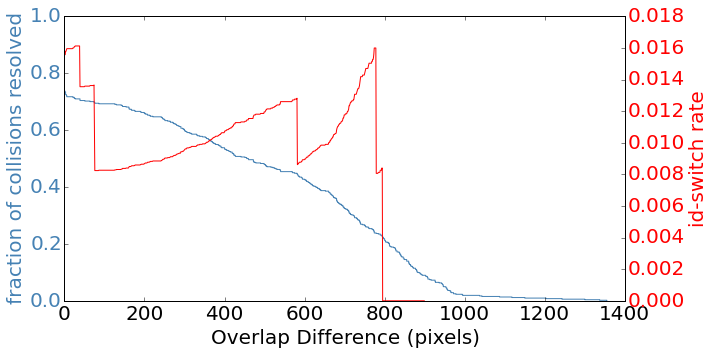

In [97]:
ser = overlap_df['pix_dif']
ser = ser.sort_values()
ser[len(ser)] = ser.iloc[-1]
cum_dist = np.linspace(0.,1.,len(ser))
ser_cdf = 1 - pd.Series(cum_dist, index=ser)

x = ser_cdf.index
y = ser_cdf

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_axis_bgcolor('white')
ax.plot(x, y, drawstyle='steps', color='steelblue')
#ser_cdf.plot(drawstyle='steps', ax=ax)
#ax.legend(loc='best', fontsize=20)
ax.set_xlabel('Overlap Difference (pixels)')
ax.set_ylabel('fraction of collisions resolved', color='steelblue')
increase_font(ax)
for tl in ax.get_yticklabels():
    tl.set_color('steelblue')

y2 = x
ax2 = ax.twinx()
ax2.plot(bx, id_switch_rate, 'r') #, drawstyle='steps')
ax2.set_ylabel('id-switch rate', color='r')
increase_font(ax2)

for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.tight_layout()
plt.savefig('collision_sweep2.png')
plt.show()

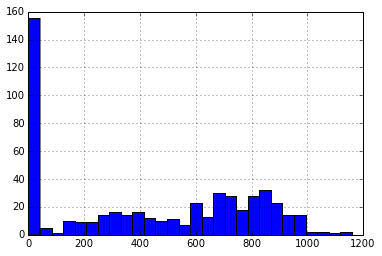

In [81]:
bins = np.linspace(0, 1200, 30)
overlap_df['pix_dif'].hist(bins=bins)

# Gaps plot

In [58]:
WALDO_DIR = pathlib.Path('/Users/peterwinter/Desktop/validation/WALDO/')

def get_all_possible_gaps(term_df):
    local_bids = term_df.index
    n_bids = len(local_bids)

    dists = pd.DataFrame(np.zeros((n_bids, n_bids)), index=local_bids, columns=local_bids)
    times = pd.DataFrame(np.zeros((n_bids, n_bids)), index=local_bids, columns=local_bids)

    for bid, row in term_df.iterrows():
        dx_row = row['xN'] - term_df['x0']
        dy_row = row['yN'] - term_df['y0']
        dt_row =  term_df['t0'] - row['tN']
        dists.loc[bid] = dx_row**2 + dy_row**2
        times.loc[bid] = dt_row
        
    dists = np.sqrt(dists)
    d = np.array(dists[times > 0]).ravel()
    t = np.array(times[times > 0]).ravel()
    d = d[np.logical_not(np.isnan(d))]
    t = t[np.logical_not(np.isnan(t))]
    
    return d, t

all_dists = []
all_times = []
for wdir in WALDO_DIR.glob('*'):
    if not wdir.is_dir():
        continue
        
    eid = wdir.name
    terminals_path = wdir / 'waldo' / (eid + '-terminals.csv')
    term_df = pd.read_csv(str(terminals_path), index_col=0)
    d, t = get_all_possible_gaps(term_df)
    all_dists.append(d)
    all_times.append(t)

In [59]:
# d = all_dists[0]
# t = all_times[0]

# d = d[np.logical_not(np.isnan(d))]
# t = t[np.logical_not(np.isnan(t))]
d = np.concatenate(all_dists)
t = np.concatenate(all_times)

In [60]:
len(d)

737004

In [61]:
#import seaborn as sns

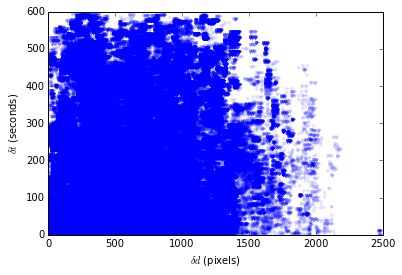

In [62]:
# d = np.array(dists[times > 0]).ravel()
# t = np.array(times[times > 0]).ravel()

fig, ax = plt.subplots()
ax.plot(d, t, '.', alpha=0.1)
ax.set_xlabel('$\delta d$ (pixels)')
ax.set_ylabel('$\delta t$ (seconds)')

plt.show()

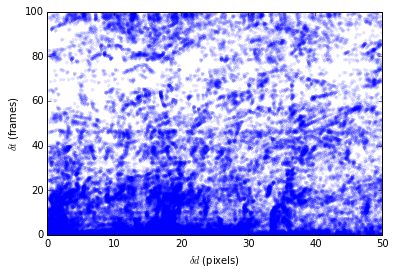

In [63]:
fig, ax = plt.subplots()
ax.plot(d, t, '.', alpha=0.1)
ax.set_xlabel('$\delta d$ (pixels)')
ax.set_ylabel('$\delta t$ (frames)')
ax.set_xlim(0, 50)
ax.set_ylim(0, 100)
plt.show()

# Part Multi. Where are transitions?

In [64]:
#A10 goes bad last instant: 0408061
#A34 starts as multi. (12 and 23). fine after 0024956 (ends with one untracked)
#B81 starts as multi. fine after 0250812 (ends with one moving into next collision/three worm collision)
#D14 fine until 0193175. (makes contact with untracked worm. speration ends track)
#H683 starts multi. good after 0505013

In [155]:
part_bad = df[df['part-bad']]

part_bad.loc['A34'] = df.loc['A34']
part_bad.loc['B81']= df.loc['B81']
part_bad.loc['H683']= df.loc['H683']

part_bad = part_bad[['Start Time', 'End Time', 'minutes']]
part_bad['transition_times'] = np.nan
part_bad['good_before_transition'] = np.nan
part_bad.loc[['A10', 'A34', 'B81', 'H683'], 'transition_times'] = [408061, 24956, 250812, 505013]
part_bad.loc[['A10', 'A34', 'B81', 'H683'], 'good_before_transition'] = [True, False, False, False]


#'A2', 0295260, 'good up until merge with worm coming out of previous collision.
# 'A5', 0112362, 'good up until merge with worm coming out of previous collision.
# 'A88', 0112362 'collision before transition. worm leaves this into another collision.
# 'A172', 0295260'collision before transition. worm leaves this into another collision.
part_bad.loc[['A2', 'A5', 'A88', 'A172'], 'transition_times'] = [295260, 112362, 112362, 295260]
part_bad.loc[['A2', 'A5', 'A88', 'A172'], 'good_before_transition'] = [True, True, False, False]


# D18 is fine...?

# B19 good before: 251845
# F13 good before 36144 ... This one is bad for really long time... consider as collision?
# H6 good before 97344
# H14 good before 18610
# H21 good after 18610
# H29 good before 480225
# H97 good after 97344.
# H104 good before 519546
# H670 good after 519546
bids = ['B19', 'F13', 'H6', 'H14', 'H21', 'H29', 'H97', 'H104', 'H670']
tts = [251845, 36144, 97344, 18610, 18610, 480225, 97344, 519546, 519546]
gbts = [True, True, True, True, False, True, False, True, False]
part_bad.loc[bids, 'transition_times'] = tts
part_bad.loc[bids, 'good_before_transition'] = gbts

#df.loc['A2']

/Users/peterwinter/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/pandas/core/indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [156]:
# aid = []
# bid2 = []
# for i in part_bad.index:
#     if 'A' in i:
#         aid.append(i)
#         bid = i.strip('A')
#         bid2.append(bid)
# print(aid)
# abad = part_bad.loc[aid]
# abad['bid2'] = bid2
# abad.to_csv('/Users/peterwinter/Desktop/validation/HUMAN/partbad_A.csv')
# abad
part_bad['total-time'] = part_bad['End Time'] - part_bad['Start Time']
part_bad['before_split'] = part_bad['transition_times'] - part_bad['Start Time']
part_bad['after_split'] = part_bad['End Time'] - part_bad['transition_times']
part_bad['good_times'] = part_bad['after_split']
before_ids = (part_bad['good_before_transition'] == True)
part_bad.loc[before_ids, 'good_times'] = part_bad.loc[before_ids, 'before_split']

part_bad['bad_times'] = part_bad['total-time'] - part_bad['good_times']

part_bad['good fraction'] =  part_bad['good_times'] / part_bad['total-time']
part_bad['bad_seconds'] = part_bad['bad_times'] / 1000
part_bad['good_seconds'] = part_bad['good_times'] / 1000

part_bad

,Start Time,End Time,minutes,transition_times,good_before_transition,total-time,before_split,after_split,good_times,bad_times,good fraction,bad_seconds,good_seconds
bid,,,,,,,,,,,,,
A2,10,305632,5.0937,295260.0,True,305622,295250,10372,295250,10372,0.966063,10.372,295.25
A5,10,128800,2.1465,112362.0,True,128790,112352,16438,112352,16438,0.872366,16.438,112.352
A10,446,413731,6.88808,408061.0,True,413285,407615,5670,407615,5670,0.986281,5.67,407.615
A34,16315,357219,5.68173,24956.0,False,340904,8641,332263,332263,8641,0.974653,8.641,332.263
A88,107931,600070,8.20232,112362.0,False,492139,4431,487708,487708,4431,0.990996,4.431,487.708
A172,287365,600070,5.21175,295260.0,False,312705,7895,304810,304810,7895,0.974753,7.895,304.81
B19,11399,278432,4.45055,251845.0,True,267033,240446,26587,240446,26587,0.900436,26.587,240.446
B81,244998,600067,5.91782,250812.0,False,355069,5814,349255,349255,5814,0.983626,5.814,349.255
D14,1229,600067,9.98063,NaN,NaN,598838,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [158]:
# D14
# good before time: 194208
# and good after time: 263442
good1 = 194208 - 1229 
bad1 = 263442 - 194208
good2 = 600067 - 263442
total = 600067 - 1229 
(good1 + good2 ) / total

part_bad.loc['D14', 'total-time'] = total
part_bad.loc['D14', 'good_times'] = good1 + good2
part_bad.loc['D14', 'bad_times'] = bad1
part_bad['good fraction'] =  part_bad['good_times'] / part_bad['total-time']
part_bad['bad_seconds'] = part_bad['bad_times'] / 1000
part_bad['good_seconds'] = part_bad['good_times'] / 1000
part_bad

,Start Time,End Time,minutes,transition_times,good_before_transition,total-time,before_split,after_split,good_times,bad_times,good fraction,bad_seconds,good_seconds
bid,,,,,,,,,,,,,
A2,10,305632,5.0937,295260.0,True,305622,295250,10372,295250,10372,0.966063,10.372,295.25
A5,10,128800,2.1465,112362.0,True,128790,112352,16438,112352,16438,0.872366,16.438,112.352
A10,446,413731,6.88808,408061.0,True,413285,407615,5670,407615,5670,0.986281,5.67,407.615
A34,16315,357219,5.68173,24956.0,False,340904,8641,332263,332263,8641,0.974653,8.641,332.263
A88,107931,600070,8.20232,112362.0,False,492139,4431,487708,487708,4431,0.990996,4.431,487.708
A172,287365,600070,5.21175,295260.0,False,312705,7895,304810,304810,7895,0.974753,7.895,304.81
B19,11399,278432,4.45055,251845.0,True,267033,240446,26587,240446,26587,0.900436,26.587,240.446
B81,244998,600067,5.91782,250812.0,False,355069,5814,349255,349255,5814,0.983626,5.814,349.255
D14,1229,600067,9.98063,NaN,NaN,598838,NaN,NaN,529604,69234,0.884386,69.234,529.604


19 part bad
16


9.506499999999999

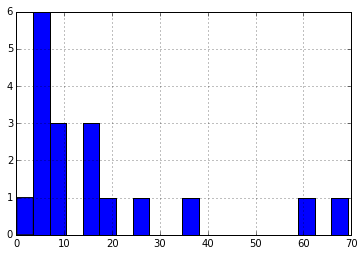

In [167]:
part_bad['bad_seconds'].hist(bins=20)
print(len(part_bad), 'part bad')
print(len(part_bad[part_bad['bad_seconds'] < 40]))
np.median(part_bad.loc[part_bad['bad_seconds'].isnull() == False, 'bad_seconds'])

In [ ]:
part_bad

In [144]:
1 - np.mean(part_bad['good fraction'])

0.036678586116682288

In [147]:
len(df[df['id-switch']]) / len(df)

0.050793650793650794

In [151]:
name_to_eid['H']

'20160712_162505-2'

In [116]:
togo = part_bad[part_bad.transition_times.isnull()]
#'A2', 295260, 'good up until merge with worm coming out of previous collision.
# 'A5', 112362, 'good up until merge with worm coming out of previous collision.
# 'A88', 112362 'collision before transition. worm leaves this into another collision.
# 'A172', 295260'collision before transition. worm leaves this into another collision.

# B19 good before: 251845
# D18 is fine...?
# F13 good before 36144 ... This one is bad for really long time... consider as collision?
# H6 good before 97344
# H14 good before 18610
# H21 good after 18610
# H29 good before 480225
# H97 good after 97344.
# H104 good before 519546
# H670 good after 519546
togo

,Start Time,End Time,minutes,transition_times,good_before_transition,total-time,before_split,after_split,good_times,bad_times,good fraction,bad_seconds
bid,,,,,,,,,,,,
B19,11399,278432,4.45055,NaN,NaN,267033,NaN,NaN,NaN,NaN,NaN,NaN
D14,1229,600067,9.98063,NaN,NaN,598838,NaN,NaN,NaN,NaN,NaN,NaN
D18,1696,4397,0.0450167,NaN,NaN,2701,NaN,NaN,NaN,NaN,NaN,NaN
F13,2032,98148,1.60193,NaN,NaN,96116,NaN,NaN,NaN,NaN,NaN,NaN
H6,498,102104,1.69343,NaN,NaN,101606,NaN,NaN,NaN,NaN,NaN,NaN
H14,1100,18670,0.292833,NaN,NaN,17570,NaN,NaN,NaN,NaN,NaN,NaN
H21,1867,600103,9.9706,NaN,NaN,598236,NaN,NaN,NaN,NaN,NaN,NaN
H29,6204,495760,8.15927,NaN,NaN,489556,NaN,NaN,NaN,NaN,NaN,NaN
H97,93504,253238,2.66223,NaN,NaN,159734,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
togo.index
[

# 'B19', 
# 'F13', 
# 'H6', 
# 'H14', 
# 'H21', 
# 'H29',
# 'H97', 
# 'H104', 
# 'H670']

SyntaxError: unexpected EOF while parsing (<ipython-input-68-64b8e97d3caa>, line 15)